## Author: Xiang (Albert) Li
## USC ID: 1892796881
## Github Userid: XiangLi1209
## Created Time: Jan 26, 2023

##### Packages Section

In [501]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math
import urllib.request
import zipfile
import io
import sklearn.metrics
from scipy.io import arff
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from tabulate import tabulate


### Q1. Vertebral Column Data Set

### This Biomedical data set was built by Dr. Henrique da Mota during a medical residence period in Lyon, France. Each patient in the data set is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and Abnormal (AB). In this exercise, we only focus on a binary classification task NO=0 and AB=1.

##### 1a) Download the Vertebral Column Data Set from: https://archive.ics.uci.edu/ml/datasets/Vertebral+Column.

In [502]:
# I actually downloaded the file into my folder, 
# so I'll just load the file directly and name it vc
vertebral_column = arff.loadarff('column_2C_weka.arff')
vc = pd.DataFrame(vertebral_column[0])

# Create another empty column, and enter 0 if class == Normal or 1 if class == Abnormal
pd.unique(list(vc['class'])) #Check the unique values of class for later filter
no_ab = [] #original class value
entry = [] #new 0/1 entry

no_ab = list(vc['class'])  # Counting the number of entries in column 'class'

for i in range(len(no_ab)):   # Appending 1 in list groups if found with label 'Abnormal' or else 0
    if no_ab[i] == b'Abnormal':
        entry.append(1)
    else:
        entry.append(0)

#vc['binary'] = entry #Add the 0/1 column into the vc dataframe
vc.head(10) #View and check the vc dataframe

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Abnormal'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Abnormal'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Abnormal'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Abnormal'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Abnormal'
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,b'Abnormal'
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,b'Abnormal'
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,b'Abnormal'
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,b'Abnormal'
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,b'Abnormal'


In [503]:
vc.replace((b'Abnormal', b'Normal'), (1, 0), inplace=True)
vc.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


##### 1b) Pre-Processing and Exploratory data analysis:
###### i. Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.

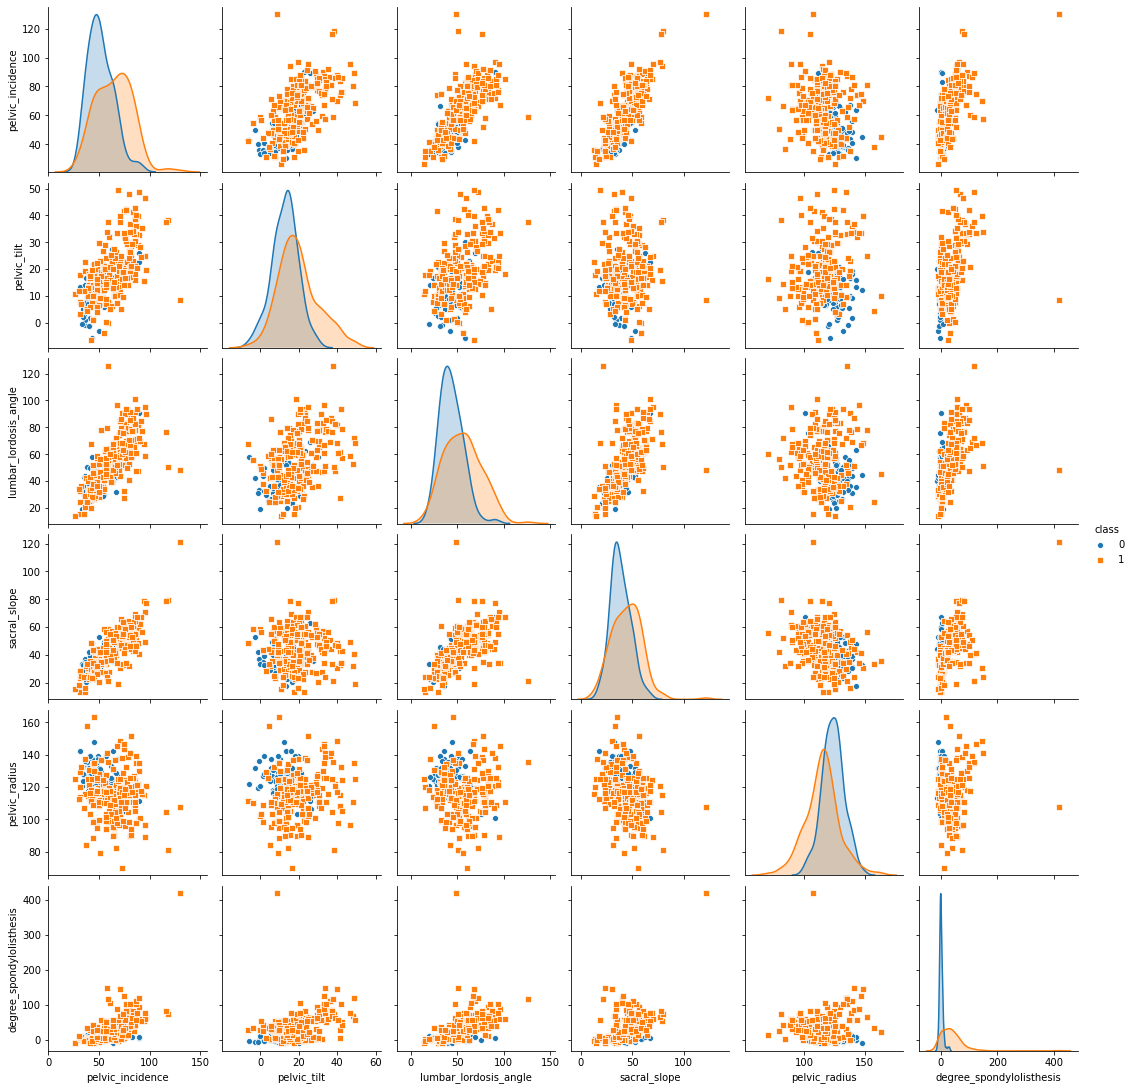

In [504]:
sns.pairplot(vc,hue = 'class',markers=["o", "s"]) 
#Using the seaborn package to make a scatter matrix, 
#with class input for color and shape differentiation
#plt.legend([],[], frameon=False)
#plt.legend(loc='lower right',title='Class', labels = ['Class 1','Class 0'])
#Add the legend for the plot, using class 0 & class 1 for instead of Normal or Abnormal

###### ii. Make boxplots for each of the independent variables. Use color to show Classes 0 and 1 (see ISLR p. 129).

Text(0.5, 1.0, 'Distribution by class')

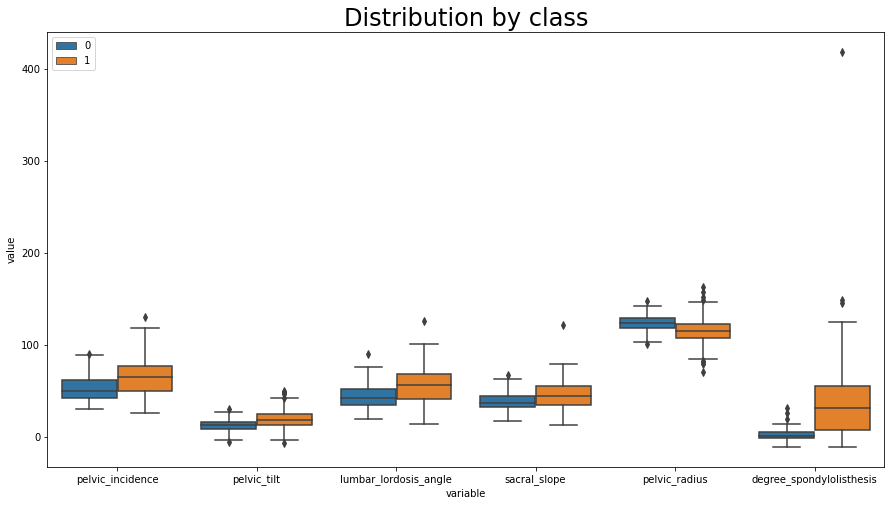

In [505]:
vc_melted = pd.melt(vc.iloc[:,:6])
entry2 = entry*6
fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(x='variable',y='value',data=vc_melted,hue = entry2)
ax.set_title( "Distribution by class" , size = 24 )

###### iii. Select the  first 70 rows of Class 0 and the  first 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [506]:
vc_class1=vc[vc['class']==1] #Creat a new sub-dataset with all class1 data
vc_class0=vc[vc['class']==0] #Creat a new sub-dataset with all class0 data

train = pd.concat([vc_class1[:140],vc_class0[:70]]) # Forming the training dataset with the given conditions
train_y = train.iloc[:,-1] #only using the class column for the train_y
train_x = train[train.columns[:6]] #using the rest of train dataset for train_x
#train.shape: (210,7), which is the correct shape we need

In [507]:
test = pd.concat([vc_class1[140:],vc_class0[70:]])#Forming the test dataset with the rest of the data
test_y = test.iloc[:,-1:] #only using the class column for the test_y
test_x = test[test.columns[:6]] #using the rest of train dataset for test_x
#test.shape: (100,7), which is also the correct shape we need as 310-210=100

In [508]:
#Shuffle all train&test x&y to min data discrepancies
#test_y = test_y.sample(frac=1)
#test_x = test_x.sample(frac=1)
#train_y = train_y.sample(frac=1)
#train_x = train_x.sample(frac=1)

##### 1c) Classification using KNN on Vertebral Column Data Set

###### i. Write code for k-nearest neighbors with Euclidean metric (or use a software package).

In [509]:
#Test case for the accuracy_scores function
def accuracy_scores(a,b):
        match = 0
        for i in range(a.shape[0]-1):
            #print(match)
            #print(a.iloc[i,0]==b.iloc[i,0])
            if(a.iloc[i,0]==b[i]):
                match+=1
                #print(match)
            else:
                match=match
        return(match/(a.shape[0]-1))

a = [['a','d','asd','fasdfd'],['d','d','a','dasd','']]
a = pd.DataFrame(a)
b = ['c','dd','asd','fasdfd']
c =['c','dd','as','fasdf']
d = ['a','d','asd','fasdfd']

print('range is',test.shape[0]-1,'first input',test.iloc[0,0],'2nd input',test.iloc[1,0],'3rd input',test.iloc[2,0])


range is 99 first input 69.56348614 2nd input 89.5049473 3rd input 85.29017283


In [510]:
#M1: Using the sklearn package's KNeighborsClassifier

def optimal_k(train_x,train_y,test_x,test_y,k_list,metric):
    test_error=[]
    train_error=[]
    k_test=[]
    k_train=[]
    def accuracy_scores(a,b):
        match = 0
        for i in range(a.shape[0]-1):
            #print(match)
            #print(a.iloc[i,0]==b.iloc[i,0])
            if(a.iloc[i,0]==b[i]):
                match+=1
                #print(match)
            else:
                match=match
        return(match/(a.shape[0]-1))

    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k,metric=metric)
        knn.fit(train_x,train_y.tolist())
        train_pred = knn.predict(train_x)
        test_pred = knn.predict(test_x)
        #confusion_matrix(test_y,test_pred,labels=[b'Abnormal',b'Normal'])
        test_error.append(1-accuracy_scores(test_y,test_pred))
        train_error.append(1-accuracy_scores(pd.DataFrame(train_y),train_pred))
    
    min_test = min(test_error)
    min_train = min(train_error)
    k_test = k_list[test_error.index(min_test)]
    k_train = k_list[train_error.index(min_train)]
        
    
    return('Optimial K based on test error is',k_list[test_error.index(min_test)],'with test_error',min_test, 
           'the optimal K based on train error is',k_list[train_error.index(min_train)],'with train error',min_train)
           
     #      'the Confusion matrix is', best_confusion_matrix,
      #     'true positive rate is',true_pos,
       #    'true negative rate is',true_neg,
        #   'precision is',precision,
         #  'and the F-score'


###### ii. Test all the data in the test database with k nearest neighbors. Take de-cisions by majority polling. Plot train and test errors in terms of k for $k \in \{208,205,...,7,4,1,\}$  (in reverse order). You are welcome to use smaller increments of k. Which $k^{*}$  is the most suitable k among those values? Calculate the confusion matrix, true positive rate, true negative rate, precision, and $F_{1}$-score when k = $k^{*}$.

In [511]:
optimal_k(train_x,train_y,test_x,test_y,
          k_list = [i for i in range(1,210,1)],metric='euclidean')
# From the result, we can see that the optimal k based on test error is 4, 
# and the optimal k based on training error is 1, which makes sense as it's a spitout model. 
# Thus I'll use 4 for the following calculation

('Optimial K based on test error is',
 4,
 'with test_error',
 0.06060606060606055,
 'the optimal K based on train error is',
 1,
 'with train error',
 0.0)

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.93      0.99      0.96        70

    accuracy                           0.94       100
   macro avg       0.95      0.91      0.93       100
weighted avg       0.94      0.94      0.94       100



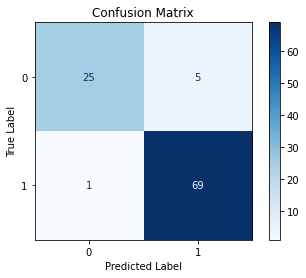

true_pos_rate is 0.9857142857142858
true_neg_rate is 0.8333333333333334
precision 0.9324324324324325
accuracy is 0.94
F1 score is 0.9583333333333333


In [512]:
test_error = []
train_error=[]
knn = KNeighborsClassifier(n_neighbors=4,metric='euclidean')
knn.fit(train_x,train_y.tolist())
train_pred = knn.predict(train_x)
test_pred = knn.predict(test_x)
test_error.append(1-accuracy_scores(test_y,test_pred))
train_error.append(1-accuracy_scores(pd.DataFrame(train_y),train_pred))
knn.score(test_x,test_y)
#From here, we know that f1-score is 0.89, accuracy is 0.94, which is also the case from the following calculation

test_y_list=test_y.values.flatten()
#test_pred_list = test_pred.values.flatten()
confusion_matrix(test_y_list.tolist(),test_pred.tolist())
print(classification_report(test_y,test_pred)) #Precision, accuracy, and f1-score

color = 'black'
matrix = plot_confusion_matrix(knn, test_x, test_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
#plt.gcf().axes[0].tick_params(colors=color)
#plt.gcf().axes[1].tick_params(colors=color)
plt.show()


#From the confusion_matrix, we know that:
TP=69
FP=5
TN=25
FN=1
print('true_pos_rate is',TP/(TP+FN))
print('true_neg_rate is',TN/(TN+FP))
print('precision', TP/(TP+FP))
print('accuracy is',(TP+TN)/(TP+TN+FP+FN))
print('F1 score is',(2*TP/(TP+FP)*TP/(TP+FN))/(TP/(TP+FP)+TP/(TP+FN)))

###### iii. Since the computation time depends on the size of the training set, one may only use a subset of the training set. Plot the best test error $rate^{3}$, which is obtained by some value of k, against the size of training set, when the size of training set is $N \in \{10,20,30,...,210\}$. Note: for each N, select your training set by choosing the  first $[N/3]$ rows of Class 0 and the first $N-[N/3]$ rows of Class 1 in the training set you created in 1(b)iii.  Also, for each N, select the optimal k from a set starting from k = 1, increasing by 5. For example, if N = 200, the optimal k is selected from $\{1,6,11,...,196\}$. This plot is called a Learning Curve.

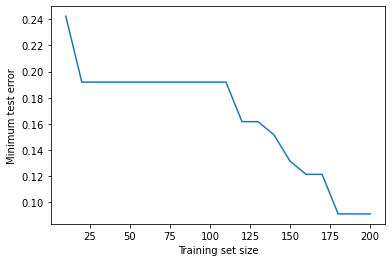

In [513]:
K_list = [i for i in range(1,197,5)]
train_set=[] #Set an empty list for the new training sets
test_set_error=[]
train_set_error=[]
train_size=[]
min_test_set=[]
min_train_set=[]
for i in range(10,210,10):
    train_set=pd.concat([vc_class1[:math.floor((i-i/3))],vc_class0[:math.floor((i/3))]]) #build 20 new training sets based on the N/3 & n-n/3 method
    test_set = test
    train_set_y = train_set.iloc[:,-1].values #only using the class column for the train_set_y
    train_set_x = train_set.iloc[:,:-1].values
    test_set_x=test_x #test_set_x & test_set_y are the same as before
    test_set_y=test_y
    train_size.append(i)
    for j in K_list:
        if j <=len(train_set_x):
            knn_set = KNeighborsClassifier(n_neighbors=j,metric='euclidean') 
            knn_set.fit(train_set_x,train_set_y)
            #make prediction based on the new knn classifier
            train_set_pred = knn_set.predict(train_set_x)
            test_set_pred = knn_set.predict(test_set_x)
            #Calculate and save the test&train errors for each model
            test_set_error.append((1-accuracy_scores(test_set_y,test_set_pred)))
            #train_set_error=(1-accuracy_scores(pd.DataFrame(train_set_y),train_set_pred))
#Find the min error for test_set_error & train_set_error and the associated k-value, for future plot comparison 
    min_test_set.append(min(test_set_error))
    #min_train_set.append(min(train_set_error))
    #k_test_set=k_list[test_set_error.index(min_test_set)]
    #k_train_set = k_list[train_set_error.index(min_train_set)]


#Training set size vs test error plot
plt.plot(train_size,min_test_set)
plt.xlabel("Training set size")
plt.ylabel("Minimum test error")
plt.show()    


##### (d) Replace the Euclidean metric with the following $metrics^{5}$ and test them. Summarize the test errors (i.e., when k = k ) in a table. Use all of your training data and select the best k when$\{1,6,11,...,196\}$.

###### i. Minkowski Distance: <br> A. which becomes Manhattan Distance with p = 1. <br> B. with log<sub>10</sub>(p) $\in\{0.1,0.2,0.3,...,1\}$. In this case, use the $k^{*}$  you found for the Manhattan distance in 1(d)iA. What is the best log10(p)? <br> C. which becomes Chebyshev Distance with ${p \to \infty}$

Optimial K based on test error is 26 with test_error 0.11111111111111116
0


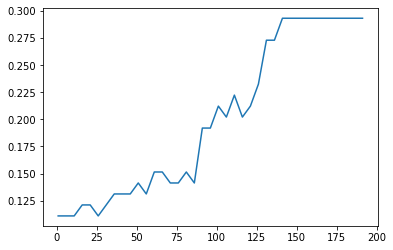

In [514]:
#Initialize new parameters for minkowski distance
test_error=[]
train_error=[]
min_test=[]
min_train=[]
k_test=[]
k_train=[]
k_list = [i for i in range(1,196,5)]

#Similar approach as the Euclidean one, just change the metric to minkowski and specify p=1
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k,metric='minkowski',p=1)
    knn.fit(train_x,train_y.tolist())
    train_pred = knn.predict(train_x)
    test_pred = knn.predict(test_x)
    test_error.append(1-accuracy_scores(test_y,test_pred))
    train_error.append(1-accuracy_scores(pd.DataFrame(train_y),train_pred))

min_test = min(test_error)
min_train = min(train_error)
k_test = k_list[test_error.index(min_test)]
k_train = k_list[train_error.index(min_train)]
print('Optimial K based on test error is',26,'with test_error',min_test)
print(test_error.index(min_test))
plt.plot(k_list,test_error)
plt.show()

Optimial p based on test error is [1.2589254117941673, 1.5848931924611136, 1.9952623149688797, 2.51188643150958, 3.1622776601683795, 3.981071705534973, 5.011872336272724, 6.309573444801933, 7.943282347242816] with test_error 0.101010101010101


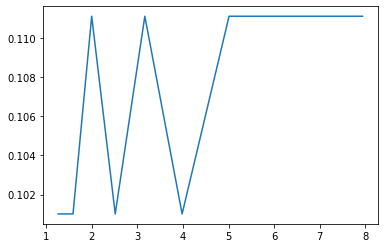

-------  -------  --------  -------  --------  -------  --------  --------  --------
1.25893  1.58489  1.99526   2.51189  3.16228   3.98107  5.01187   6.30957   7.94328
0.10101  0.10101  0.111111  0.10101  0.111111  0.10101  0.111111  0.111111  0.111111
-------  -------  --------  -------  --------  -------  --------  --------  --------


In [515]:
#Initialize new parameters for minkowski distance
p_list=[]
test_minko_error=[]
train_minko_error=[]
#Set up the p_list accordingly
for i in range(1,10,1):
    p_list.append(10**(0.1*i))
    
#Build KNN models with different p-value and the optimal k=4 calculated from above
for j in p_list:
    knn = KNeighborsClassifier(n_neighbors=26,metric='minkowski',p=j)
    knn.fit(train_x,train_y.tolist())
    train_pred = knn.predict(train_x)
    test_pred = knn.predict(test_x)
    test_minko_error.append(1-accuracy_scores(test_y,test_pred))
    train_minko_error.append(1-accuracy_scores(pd.DataFrame(train_y),train_pred))
    
#Check the best model by checking min error and its matching p-value
min_test_minko = min(test_minko_error)
min_train_minko = min(train_minko_error)
#print(min_test_minko,min_train_minko)

p_test=p_list[test_minko_error.index(min_test_minko):]
p_train=p_list[train_minko_error.index(min_train_minko)]

print('Optimial p based on test error is',p_test,'with test_error',min_test_minko)

#Draw a plot to visualize it
plt.plot(p_list,test_minko_error)
plt.show()

print(tabulate([p_list,test_minko_error]))

The optimal k using Chebyshev Distance based on test error is 16 with test error 0.08080808080808077


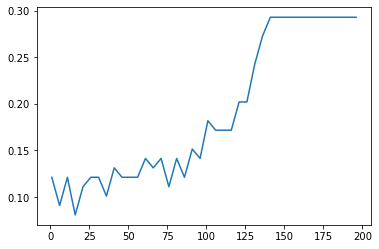

In [516]:
#Initialize new parameters for Chebyshev distance, using the same methods, but magnify the p-value

k_list = [i for i in range(1,197,5)]
test_che_error=[]
train_che_error=[]
    
for k in k_list:
    knn_che = KNeighborsClassifier(n_neighbors=k,metric='chebyshev')
    knn_che.fit(train_x,train_y.tolist())
    train_pred = knn_che.predict(train_x)
    test_pred = knn_che.predict(test_x)
    test_che_error.append(1-accuracy_scores(test_y,test_pred))
    train_che_error.append(1-accuracy_scores(pd.DataFrame(train_y),train_pred))

min_test_che = min(test_che_error)
min_train_che = min(train_che_error)
#print(min_test_minko,min_train_minko)

k_test=k_list[test_che_error.index(min_test_che)]
k_train=k_list[train_che_error.index(min_train_che)]
#print(p_test,p_train)

print('The optimal k using Chebyshev Distance based on test error is',k_test, 'with test error',min_test_che)

#Draw a plot to visualize the trend
plt.plot(k_list,test_che_error)
plt.show()


###### ii. Mahalanobis $Distance^{6}$

Optimial K based on test error is 1 with test_error 0.13131313131313127


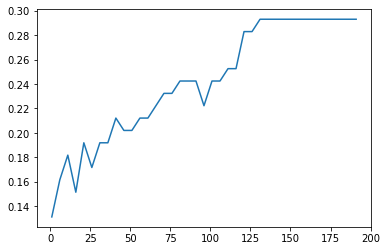

In [517]:
test_error=[]
train_error=[]
k_test=[]
k_train=[]
k_list = [i for i in range(1,196,5)]

#Similar approach as the Euclidean one, just change the metric to minkowski and specify p=1
for k in k_list:

    knn_mah=KNeighborsClassifier(n_neighbors = k,metric='mahalanobis',
                     metric_params={'VI': np.linalg.inv(np.cov(train_x,rowvar=False))})    
    knn_mah.fit(train_x,train_y.tolist())
    train_pred = knn_mah.predict(train_x)
    test_pred = knn_mah.predict(test_x)
    test_error.append(1-accuracy_scores(test_y,test_pred))
    train_error.append(1-accuracy_scores(pd.DataFrame(train_y),train_pred))

min_test = min(test_error)
min_train = min(train_error)
k_test = k_list[test_error.index(min_test)]
k_train = k_list[train_error.index(min_train)]
print('Optimial K based on test error is',k_list[test_error.index(min_test)],'with test_error',min_test)

plt.plot(k_list,test_error)
plt.show()

###### (e) The majority polling decision can be replaced by weighted decision, in which the weight of each point in voting is inversely proportional to its distance from the query/test data point. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when $k \in \{1,6,11,...,196\}$.

In [518]:
best_k_eu = None
best_accuracy_eu = 0

# Loop over different values of k
for k in range(1, 196, 5):
    # Create a KNeighborsClassifier object with k neighbors
    knn_eu = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean',weights='distance')
    
    # Fit the model on the training data
    knn_eu.fit(train_x,train_y)
    
    # Make predictions on the test data
    y_pred = knn_eu.predict(test_x)
    
    # Compute the accuracy
    accuracy = accuracy_score(test_y, y_pred)

    # Update the best k and best accuracy if necessary
    if accuracy > best_accuracy_eu:
        best_k_eu = k
        best_accuracy_eu = accuracy


print("Best k for Euclidean:", best_k_eu)
print("Best test errors for Euclidean:", 1-best_accuracy_eu)


Best k for Euclidean: 6
Best test errors for Euclidean: 0.09999999999999998


In [519]:
best_k_man = None
best_accuracy_man = 0

# Loop over different values of k
for k in range(1, 196, 5):
    # Create a KNeighborsClassifier object with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'manhattan',weights='distance')
    
    # Fit the model on the training data
    knn.fit(train_x,train_y)
    
    # Make predictions on the test data
    y_pred = knn.predict(test_x)
    
    # Compute the accuracy
    accuracy = accuracy_score(test_y, y_pred)
    
    # Update the best k and best accuracy if necessary
    if accuracy > best_accuracy_man:
        best_k_man = k
        best_accuracy_man = accuracy

print("Best k for Manhattan:", best_k_man)
print("Best test errors for Manhattan:", 1-best_accuracy_man)

Best k for Manhattan: 26
Best test errors for Manhattan: 0.09999999999999998


In [520]:
best_k_che = None
best_accuracy_che = 0

# Loop over different values of k
for k in range(1, 196, 5):
    # Create a KNeighborsClassifier object with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'chebyshev',weights='distance')
    
    # Fit the model on the training data
    knn.fit(train_x,train_y)
    
    # Make predictions on the test data
    y_pred = knn.predict(test_x)
    
    # Compute the accuracy
    accuracy = accuracy_score(test_y, y_pred)
    
    # Update the best k and best accuracy if necessary
    if accuracy > best_accuracy_che:
        best_k_che = k
        best_accuracy_che = accuracy

print("Best k for Chebyshev:", best_k_che)
print("Best best error for Chebyshev:", 1-best_accuracy_che)

Best k for Chebyshev: 16
Best best error for Chebyshev: 0.10999999999999999


In [521]:
table = [['Metrics', 'best k', 'best error'], 
         ['Euclidean', best_k_eu, 1-best_accuracy_eu], 
         ['Manhattan', best_k_man, 1-best_accuracy_man], 
         ['Chebyshev', best_k_che, 1-best_accuracy_che]]
print(tabulate(table))

---------  ------  -------------------
Metrics    best k  best error
Euclidean  6       0.09999999999999998
Manhattan  26      0.09999999999999998
Chebyshev  16      0.10999999999999999
---------  ------  -------------------


###### (f) What is the lowest training error rate you achieved in this homework?

## The lowest training error that i achieved is 0, which makes sense as k=1, the training model would become a spit out model, that would no mistake but also would contribute little to no value as well.